In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, ImageColorGenerator

# Magic command and plot style - matplotlib.pyplot
%matplotlib inline
plt.style.use('seaborn-darkgrid')

    # Do not display future warnings
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 100)

### Load data

In [3]:
df = pd.read_pickle('./data/reddit.pkl')

In [4]:
# Check first 5 rows
df.head(5)

,selftext,subreddit,title
0,[removed],Android,Contact Pictures Pixelated
1,,Android,"Samsung Galaxy Z Fold4, Z Flip4 fully revealed"
2,[removed],Android,Motorola G71 vs. Motorola G60 vs. Galaxy A53 (...
3,,Android,European War 7: Medieval Mod_Hack Unlocked Ful...
4,,Android,Malware hits millions of Android users — delet...


In [5]:
#setting '[removed]' and '[deleted]' as blank
df['selftext'] = np.where(df['selftext']=='[removed]' , "", df['selftext'])
df['selftext'] = np.where(df['selftext']=='[deleted]' , "", df['selftext'])
df['title'] = np.where(df['title']=='[removed]' , "", df['title'])
df['title'] = np.where(df['title']=='[deleted]' , "", df['title'])

In [6]:
df.head()

,selftext,subreddit,title
0,,Android,Contact Pictures Pixelated
1,,Android,"Samsung Galaxy Z Fold4, Z Flip4 fully revealed"
2,,Android,Motorola G71 vs. Motorola G60 vs. Galaxy A53 (...
3,,Android,European War 7: Medieval Mod_Hack Unlocked Ful...
4,,Android,Malware hits millions of Android users — delet...


In [7]:
#fill all Nan with empty string
df = df.fillna('')

In [8]:
#combine title and selftext
df['text'] = df['selftext'] + df['title']

In [9]:
df.drop(columns=['selftext', 'title'], axis=1, inplace= True)

In [10]:
#there are non english words in the data
df.shape

(21964, 2)

In [11]:
df.isnull().sum()

subreddit    0
text         0
dtype: int64

In [12]:
#remove emojis, and non english words

#df  = df[~df['text'].str.contains(r'[^\x00-\x7F]')]

In [13]:
#replace emojis, and non english words with ""
df['text'] = df['text'].str.replace(r'[^\x00-\x7F]', '', regex=True)

In [14]:
df.shape

(21964, 2)

In [15]:
df.head()

,subreddit,text
0,Android,Contact Pictures Pixelated
1,Android,"Samsung Galaxy Z Fold4, Z Flip4 fully revealed"
2,Android,Motorola G71 vs. Motorola G60 vs. Galaxy A53 (...
3,Android,European War 7: Medieval Mod_Hack Unlocked Ful...
4,Android,Malware hits millions of Android users delete...


In [16]:
df.value_counts('subreddit')

subreddit
apple      10984
Android    10980
dtype: int64

### Removing space,tab and breakline and stop words:

In [17]:
def clean_text(text_to_clean):
    text_to_clean = re.sub( '[^a-zA-Z0-9]', ' ', text_to_clean) # subs charact in the brackets
    text_to_clean = re.sub( '\s+', ' ', text_to_clean).strip() ## subs tabs,newlines and "whitespace-like"
    words = text_to_clean.lower().split() ## convert to lowercase split indv words 
    
    #converting stop words to set
    stops = stopwords.words('english')
    #adding new words that may be common between both subs
    newStopWords=('phone', 'tablet', 'system') 
    stops.extend(newStopWords)
    
    meaningful_words = [w for w in words if not w in stops] # removing stop words
    return(" ".join(meaningful_words))

In [18]:
df['clean_text'] = df.apply(lambda x: clean_text(x['text']), axis=1)

### Lemmatize Text

In [19]:
# define function to lemmatize text data

def lemmatize_text(text):
    # instantiate RegexpTokenizer and WordNetLemmatizer
    tokenizer = RegexpTokenizer('\w+')
    lemmatizer = WordNetLemmatizer()
    
    # tokenize text data
    tokens = tokenizer.tokenize(text)
    lemmatized_tokens = []
    
    # lemmatize only words that are not stopwords so they are still recognized as stopwords
    for i in tokens:
        i = lemmatizer.lemmatize(i)
        lemmatized_tokens.append(i)
    
    # combine words into text data again
    lemmatized_text = " ".join(lemmatized_tokens)
    
    return lemmatized_text

In [20]:
df['clean_text'] = df['clean_text'].apply(lemmatize_text)

In [21]:
df

,subreddit,text,clean_text
0,Android,Contact Pictures Pixelated,contact picture pixelated
1,Android,"Samsung Galaxy Z Fold4, Z Flip4 fully revealed",samsung galaxy z fold4 z flip4 fully revealed
2,Android,Motorola G71 vs. Motorola G60 vs. Galaxy A53 (...,motorola g71 v motorola g60 v galaxy a53 heard...
3,Android,European War 7: Medieval Mod_Hack Unlocked Ful...,european war 7 medieval mod hack unlocked full...
4,Android,Malware hits millions of Android users delete...,malware hit million android user delete apps r...
...,...,...,...
21959,apple,IPHONE 13 HIDDEN FEATURES AND TRICKS,iphone 13 hidden feature trick
21960,apple,Apple's secret,apple secret
21961,apple,Shared Albums disappeared overnight apart from...,shared album disappeared overnight apart lates...
21962,apple,Apple's secret,apple secret


In [22]:
print("Total nulls:" , df.isnull().sum().sum())

Total nulls: 0


In [23]:
df.isnull().sum()

subreddit     0
text          0
clean_text    0
dtype: int64

### Feature Engineering

In [24]:
# Create function to tokenize 'body'
def tokenizer(x):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(x)

In [25]:
df['tokens'] = df['clean_text'].map(tokenizer)

In [26]:
#Replacing blank values (white space) with NaN 
df = df.replace(r'^\s*$', np.nan, regex=True)

### Data Cleaning

In [27]:
df[df.isna().any(axis=1)]

,subreddit,text,clean_text,tokens
5,Android,NaN,NaN,[]
54,Android,NaN,NaN,[]
210,Android,We are here!!!,NaN,[]
342,Android,NaN,NaN,[]
416,Android,NaN,NaN,[]
487,Android,NaN,NaN,[]
847,Android,NaN,NaN,[]
918,Android,NaN,NaN,[]
1036,Android,NaN,NaN,[]
1141,Android,-,NaN,[]


In [28]:
df = df.dropna()

In [29]:
df.isnull().sum()

subreddit     0
text          0
clean_text    0
tokens        0
dtype: int64

In [30]:
df.groupby(['subreddit']).count()

,text,clean_text,tokens
subreddit,,,
Android,10939,10939,10939
apple,10966,10966,10966


### Data Imbalance
To prevent data in balance we will take 10900 data from each subreddit for further processing,  

In [31]:
df_android = df[df.subreddit == 'Android']
df_android = df_android.head(10900)
df_apple = df[df.subreddit == 'apple']
df_apple = df_apple.head(10900)

In [32]:
print("android shape", df_android.shape)
print("apple shape", df_apple.shape)

android shape (10900, 4)
apple shape (10900, 4)


In [33]:
#combine them back into one dataframe
df = pd.concat([df_apple, df_android], axis=0, join='outer',ignore_index=False)
df.reset_index(drop=True, inplace=True)

### Creating Label column

apple = 0  
Android = 1


In [34]:
df['label'] = df['subreddit'].map({'apple':0,'Android':1})

In [35]:
df

,subreddit,text,clean_text,tokens,label
0,apple,"I locked my MacBook when it was lost, through ...",locked macbook lost find app activate help,"[locked, macbook, lost, find, app, activate, h...",0
1,apple,Apple's M2 MacBook Pro Sees First Ever Discoun...,apple m2 macbook pro see first ever discount 2...,"[apple, m2, macbook, pro, see, first, ever, di...",0
2,apple,Home Automation,home automation,"[home, automation]",0
3,apple,Apple's customer service beyond Apple Care is ...,apple customer service beyond apple care actua...,"[apple, customer, service, beyond, apple, care...",0
4,apple,Not sure if this is the right place to get hel...,sure right place get help quick,"[sure, right, place, get, help, quick]",0
...,...,...,...,...,...
21795,Android,S21+ at BB for 949.99?,s21 bb 949 99,"[s21, bb, 949, 99]",1
21796,Android,How to mute individual conversations on Androi...,mute individual conversation android 12,"[mute, individual, conversation, android, 12]",1
21797,Android,Honor Magic 4: All we know so far about the up...,honor magic 4 know far upcoming premium smartp...,"[honor, magic, 4, know, far, upcoming, premium...",1
21798,Android,Top 5 Samsung Galaxy Best Phones Under 50000 F...,top 5 samsung galaxy best phone 50000 money,"[top, 5, samsung, galaxy, best, phone, 50000, ...",1


### Removing un-used columns:

In [36]:
drop_columns = ['subreddit','text','tokens']
df.drop(columns=drop_columns,axis=1,inplace=True)

In [37]:
df

,clean_text,label
0,locked macbook lost find app activate help,0
1,apple m2 macbook pro see first ever discount 2...,0
2,home automation,0
3,apple customer service beyond apple care actua...,0
4,sure right place get help quick,0
...,...,...
21795,s21 bb 949 99,1
21796,mute individual conversation android 12,1
21797,honor magic 4 know far upcoming premium smartp...,1
21798,top 5 samsung galaxy best phone 50000 money,1


### Cheking most comon words for each class

In [38]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [39]:
#android
split_android_series = df.loc[df['label']==1,:]['clean_text'].str.split()
words_android = []
for value in split_android_series:
    words_android = words_android + value
print("android word count length:", len(words_android))
android_com_words = sortFreqDict(wordListToFreqDict(words_android))[0:15]
df_android_com_words= pd.DataFrame(android_com_words,columns=['count','word'])
df_android_com_words.head(15)

android word count length: 102847


,count,word
0,3487,android
1,1267,wiki
2,1225,com
3,1221,http
4,1187,r
5,1081,reddit
6,1015,google
7,996,www
8,978,app
9,895,samsung


In [40]:
#apple
split_apple_series = df.loc[df['label']==0,:]['clean_text'].str.split()
words_apple = []
for value in split_apple_series:
    words_apple = words_apple + value
print("apple word count length:", len(words_apple))
#display("apple title common words",sortFreqDict(wordListToFreqDict(words_apple))[0:15])
apple_com_words = sortFreqDict(wordListToFreqDict(words_apple))[0:15]
df_apple_com_words= pd.DataFrame(apple_com_words,columns=['count','word'])
df_apple_com_words.head(15)

apple word count length: 105293


,count,word
0,3977,apple
1,1679,iphone
2,1430,pro
3,1143,app
4,1042,new
5,1009,macbook
6,866,thread
7,731,http
8,667,advice
9,657,ipad


Text(0.5, 0.14327136594005552, 'Android')

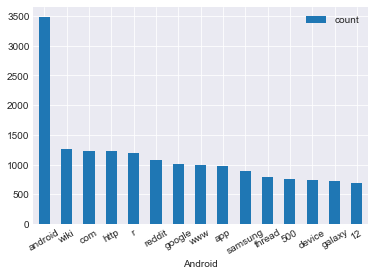

In [41]:
#plt.figure(figsize=(14,9))

df_android_com_words.set_index('word').plot(kind='bar')
plt.xticks(rotation=30)

plt.savefig("./images/aaplb4.png", format="png")
plt.xlabel('Android')

Text(0.5, 0.3307713659400555, 'Apple')

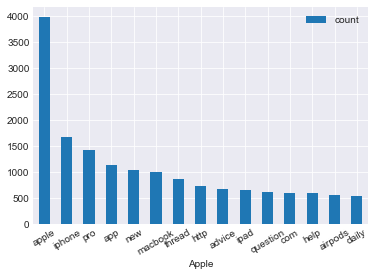

In [42]:
df_apple_com_words.set_index('word').plot(kind='bar')
plt.xticks(rotation=30)

plt.savefig("./images/aaplb4.png", format="png")
plt.xlabel('Apple')

Notice there are some common words such as new, app/apps, https, help etc.  
in order to improve our model, we will be adding these words into our stop list

### Adding additional/common stop words

In [43]:
#re-doing stop words with more stopwords added


def clean_text2(text_to_clean):
    text_to_clean = re.sub( '[^a-zA-Z0-9]', ' ', text_to_clean) # subs charact in the brackets
    text_to_clean = re.sub( '\s+', ' ', text_to_clean).strip() ## subs tabs,newlines and "whitespace-like"
    words = text_to_clean.lower().split() ## convert to lowercase split indv words 
    
    #converting stop words to set
    stops = stopwords.words('english')
    #adding new words that may be common between both subs
    newStopWords2=('phone', 'tablet', 'system','https', 'help','app','apps','new','com','www','http') 
    stops.extend(newStopWords2)
    
    meaningful_words = [w for w in words if not w in stops] # removing stop words
    return(" ".join(meaningful_words))

In [44]:
df['clean_text'] = df.apply(lambda x: clean_text2(x['clean_text']), axis=1)

In [45]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [46]:
df

,clean_text,label
0,locked macbook lost find activate,0
1,apple m2 macbook pro see first ever discount 2...,0
2,home automation,0
3,apple customer service beyond apple care actua...,0
4,sure right place get quick,0
...,...,...
21795,s21 bb 949 99,1
21796,mute individual conversation android 12,1
21797,honor magic 4 know far upcoming premium smartp...,1
21798,top 5 samsung galaxy best 50000 money,1


In [47]:
#checking for numm values
df[df.isna().any(axis=1)]

,clean_text,label
146,NaN,0
385,NaN,0
403,NaN,0
1007,NaN,0
1018,NaN,0
1028,NaN,0
1259,NaN,0
1423,NaN,0
1506,NaN,0
1769,NaN,0


In [48]:
#dropping null
df.dropna(inplace=True)

In [49]:
df_android = df[df['label'] == 1]
df_android = df_android.head(10000)
df_apple = df[df['label'] == 0]
df_apple = df_apple.head(10000)

In [50]:
print("android shape", df_android.shape)
print("apple shape", df_apple.shape)

android shape (10000, 2)
apple shape (10000, 2)


In [51]:
#combine them back into one dataframe

df = pd.concat([df_apple, df_android], axis=0, join='outer',ignore_index=False)
df.reset_index(drop=True, inplace=True)

In [52]:
df

,clean_text,label
0,locked macbook lost find activate,0
1,apple m2 macbook pro see first ever discount 2...,0
2,home automation,0
3,apple customer service beyond apple care actua...,0
4,sure right place get quick,0
...,...,...
19995,libsu 4 0 0 released proper multi user support...,1
19996,samsung galaxy s22 s21 power restart,1
19997,google play false dmca complaint ruin life dev...,1
19998,nokia unveils 3 budget android 11 go,1


In [53]:
#apple
split_apple_series = df.loc[df['label']==0,:]['clean_text'].str.split()
words_apple = []
for value in split_apple_series:
    words_apple = words_apple + value
print("apple word count length:", len(words_apple))
#display("apple title common words",sortFreqDict(wordListToFreqDict(words_apple))[0:15])
apple_com_words = sortFreqDict(wordListToFreqDict(words_apple))[0:15]
df_apple_com_words= pd.DataFrame(apple_com_words,columns=['count','word'])
df_apple_com_words.head(15)


apple word count length: 92806


,count,word
0,3688,apple
1,1533,iphone
2,1290,pro
3,915,macbook
4,806,thread
5,621,advice
6,610,ipad
7,571,question
8,501,daily
9,495,airpods


In [54]:
#android
split_android_series = df.loc[df['label']==1,:]['clean_text'].str.split()
words_android = []
for value in split_android_series:
    words_android = words_android + value
print("android word count length:", len(words_android))
android_com_words = sortFreqDict(wordListToFreqDict(words_android))[0:15]
df_android_com_words= pd.DataFrame(android_com_words,columns=['count','word'])
df_android_com_words.head(15)

android word count length: 88505


,count,word
0,3213,android
1,1176,wiki
2,1107,r
3,1005,reddit
4,947,google
5,802,samsung
6,742,thread
7,722,500
8,676,device
9,651,12


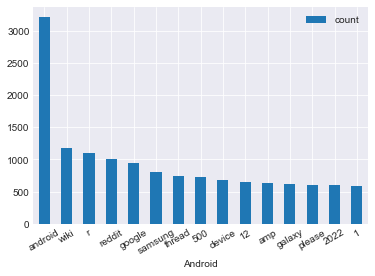

In [55]:
df_android_com_words.set_index('word').plot(kind='bar')
plt.xticks(rotation=30)
plt.xlabel('Android')
plt.savefig("./images/android_after.png", format="png")

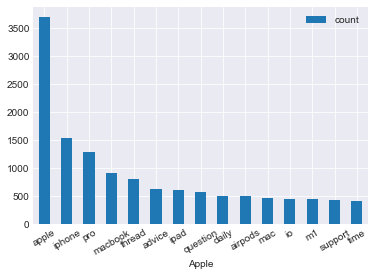

In [56]:
df_apple_com_words.set_index('word').plot(kind='bar')
plt.xticks(rotation=30)
plt.xlabel('Apple')
plt.savefig("./images/aapl_after.png", format="png")

### Creating Word Cloud

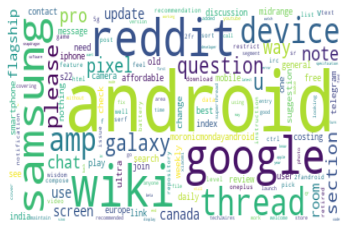

In [57]:
android = " ".join(review for review in df[df["label"]==1]['clean_text'])
#Create and generate a word cloud image:
wordcloud_android = WordCloud(collocations=False,background_color="white", max_words=150).generate(android)

# Display the generated image:
plt.imshow(wordcloud_android, interpolation='bilinear',aspect="auto")
plt.axis("off")
# store to file
plt.savefig("./images/android_word_cloud.png", format="png")
plt.show()

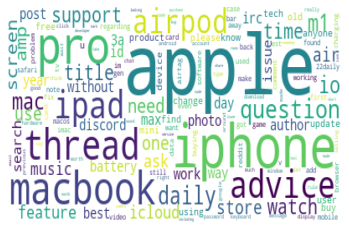

In [58]:
apple = " ".join(review for review in df[df["label"]==0]['clean_text'])
#Create and generate a word cloud image:
wordcloud_apple = WordCloud(collocations=False,background_color="white", max_words=150).generate(apple)

# Display the generated image:
plt.imshow(wordcloud_apple, interpolation='bilinear',aspect="auto")
plt.axis("off")
# store to file
plt.savefig("./images/apple_word_cloud.png", format="png")
plt.show()

In [59]:
df.to_csv('./data/reddit_cleaned_data.csv',index=False)